In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [0]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32
DIRECTORY = '/dataset/'

In [0]:
def images_converter(directory):
  # grab the list of images in our dataset directory, then initialize
  # the list of data (i.e., images) and class images
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(directory))
  data = []
  labels = []

  # loop over the image paths
  for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
  return data, labels


In [23]:

data, labels = images_converter(DIRECTORY)

[INFO] loading images...


In [24]:
print(f'shape of data{data.shape}, shape of labels {labels.shape}')

shape of data(194, 224, 224, 3), shape of labels (194,)


In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [0]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [28]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
#build our model 
i = baseModel.output
x = AveragePooling2D(pool_size=(5, 5))(i)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

model = Model(baseModel.input, x)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
	metrics=["accuracy"])

In [46]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [47]:
r = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/10
4/4 [==============================] - 2s 576ms/step - loss: 0.5962 - accuracy: 0.6585 - val_loss: 0.5111 - val_accuracy: 0.6667
Epoch 2/10
4/4 [==============================] - 1s 304ms/step - loss: 0.3789 - accuracy: 0.8455 - val_loss: 0.3679 - val_accuracy: 0.8205
Epoch 3/10
4/4 [==============================] - 1s 326ms/step - loss: 0.3195 - accuracy: 0.8984 - val_loss: 0.2791 - val_accuracy: 0.9487
Epoch 4/10
4/4 [==============================] - 1s 305ms/step - loss: 0.2467 - accuracy: 0.9268 - val_loss: 0.2229 - val_accuracy: 0.9744
Epoch 5/10
4/4 [==============================] - 1s 307ms/step - loss: 0.1581 - accuracy: 0.9593 - val_loss: 0.1887 - val_accuracy: 0.9744
Epoch 6/10
4/4 [==============================] - 1s 310ms/step - loss: 0.1162 - accuracy: 0.9756 - val_loss: 0.1669 - val_accuracy: 0.9744
Epoch 7/10
4/4 [==============================] - 1s 314ms/step - loss: 0.1584 - accuracy: 0.9593 - val_loss: 0.1475 - val_accuracy: 0.9744
Epoch 8/10
4/4 [====

In [0]:
predictions = model.predict(testX, batch_size=BS)


              precision    recall  f1-score   support

   with_mask       1.00      0.95      0.97        19
without_mask       0.95      1.00      0.98        20

    accuracy                           0.97        39
   macro avg       0.98      0.97      0.97        39
weighted avg       0.98      0.97      0.97        39

[INFO] saving mask detector model...


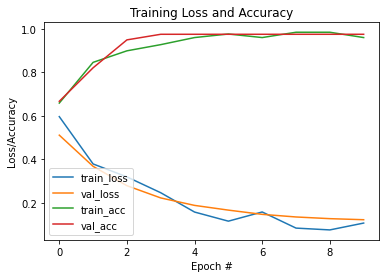

In [49]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predictions_index = np.argmax(predictions, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predictions_index,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/mask_detection.model', save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.figure()
plt.plot(np.arange(0, N), r.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), r.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), r.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), r.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")